An example of how to read Goddard GRACE/GRACE-FO Mascons file

In [1]:
# load xarray for netcdf reading
import xarray as xr
import pandas as pd
import numpy as np
# load pygmt for ploting (optional)
import pygmt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
%cd /content/drive/My Drive/folder_name

reading netCDF data file

In [17]:
ncfile="C:\\Users\PMYLS\\Documents\\Projects\\GRACE.ipynb\\gsfc.glb_.200204_202309_rl06v2.0_obp-ice6gd_halfdegree.nc"

In [18]:
try:
    with xr.open_dataset(
            filename_or_obj=ncfile, engine='netcdf4') as ds:
        dimensions = dict(ds.dims)
        variables = ds.variables
        attributes = ds.attrs
except Exception as err:
    pass

C:\Users\PMYLS\AppData\Local\Temp\ipykernel_14100\2110520501.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dimensions = dict(ds.dims)


In [19]:
ds = xr.open_dataset(ncfile,mask_and_scale=True)

In [20]:
# print summary of data
ds

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 225, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-18 2002-05-11 ... 2023-09-16
Dimensions without coordinates: bounds
Data variables:
    land_mask      (lat, lon) float64 ...
    lwe_thickness  (time, lat, lon) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/25)
    title:                      NASA GSFC GRACE and GRACE-FO MASCON RL06 v1.0
    summary:                    Monthly gravity solutions from GRACE and GRAC...
    platform:                   GRACE and GRACE-FO
    creator_name:               Bryant Loomis
    creator_email:              bryant.d.loomis@nasa.gov
    creator_url:                https://earth.gsfc.nasa.gov/geo/data/grace-ma...
    ...                         ...
    GIA_removed:                ICE6G-D; Peltier, W. R., D. F. Argus, and R. ...
    geocenter_correction:       JPL TN-13
    C_20_substitution:          TN-14; Loomis et al., 2020, Geophys. Res. Let...
    C_30_substitution:          TN-14; Loomis et al., 2020, Geophys. Res. Let...
    journal_reference:          Loomis et al. 2019, J. Geod., https://doi.org...
    date_created:               date_stamp

get variables we need

In [21]:
lwe  = ds['lwe_thickness']
time = ds['time']
lon = ds['lon']
lat = ds['lat']
mask = ds['land_mask']

In [22]:
# this is just to have a matrix of grid nodes
ll,lt=np.meshgrid(lon,lat)

We apply mask ocean

In [23]:
mask.values.shape

(360, 720)

In [24]:
lwe.values.shape

(225, 360, 720)

In [25]:
ewh = lwe*mask

In [26]:
ewh.values.shape

(225, 360, 720)

We convert the time to datetime for dataframe manipulations if you wish (optional)

In [27]:
dates_array = pd.to_datetime(time)
dates_pd = dates_array.strftime("%Y-%b-%d")
dates = []
time_arr = []
for i in range(len(time)):
    time_arr.append(i)
    dates.append(dates_pd.values[i])

ntime=len(time)

Lets plot one epoch

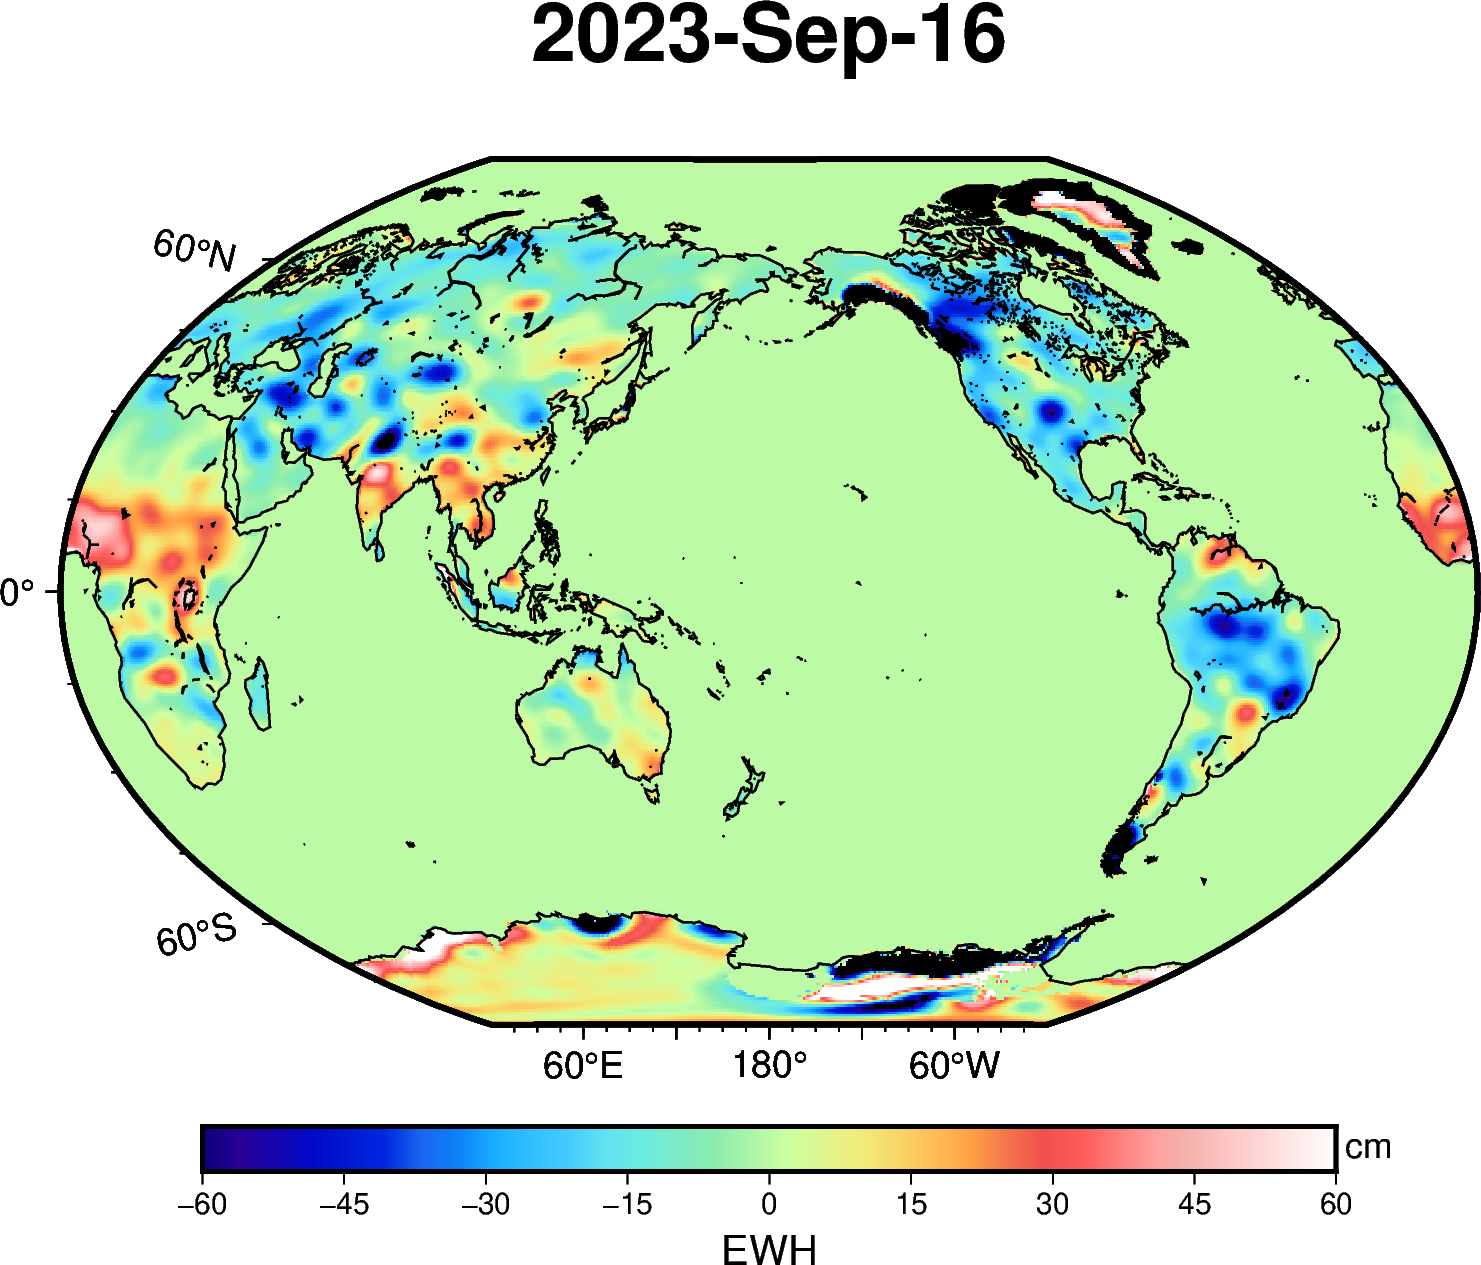

In [28]:
pdate="2023-Sep-16"

idx = dates.index(pdate)
fig = pygmt.Figure()
pygmt.makecpt(series=[-60., 60.], cmap="haxby")
fig.grdimage(grid=ewh[idx,:,:],projection="R12c")
fig.coast(shorelines="0.5p,black", frame="af")
fig.colorbar(frame=["a15", "x+lEWH", "y+lcm"])
fig.basemap(frame=["a", "+t"+dates[idx]])
fig.show()

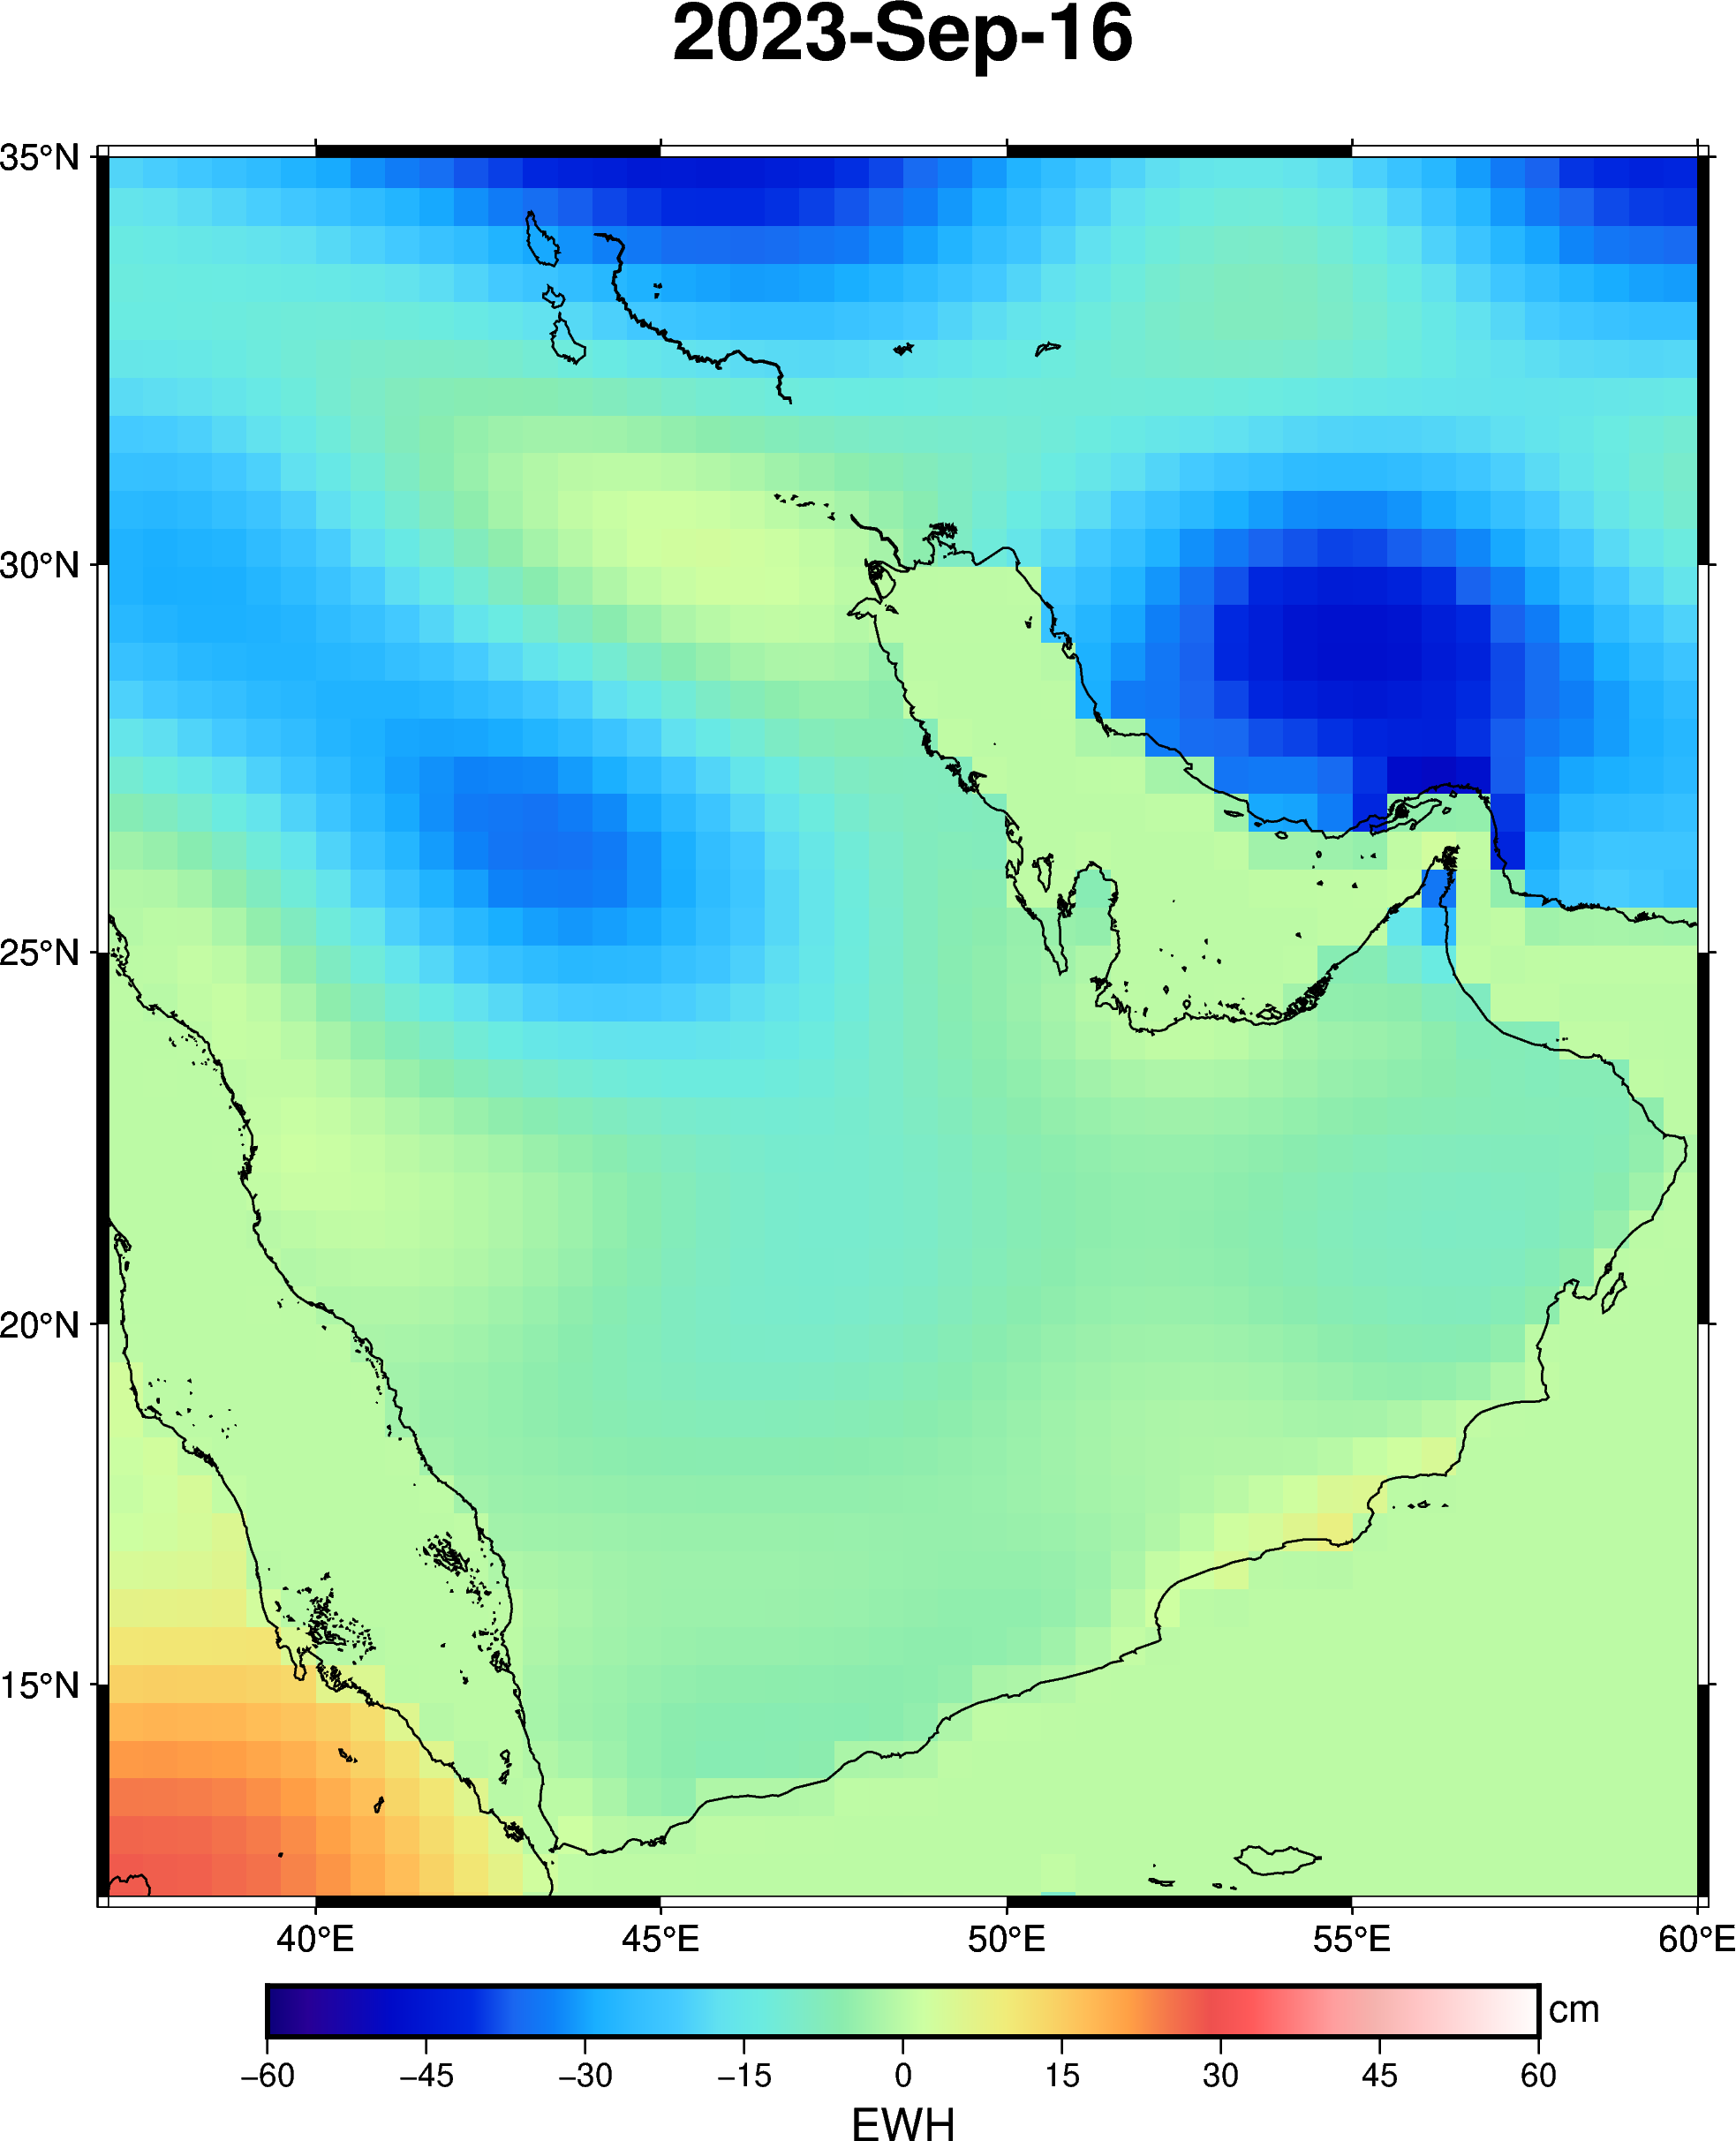

In [29]:
pdate = "2023-Sep-16"

idx = dates.index(pdate)
fig = pygmt.Figure()

# Set the region to focus on the Arabia region
region = [37, 60, 12, 35]  # [lon_min, lon_max, lat_min, lat_max]

pygmt.makecpt(series=[-60., 60.], cmap="haxby")
fig.grdimage(grid=ewh[idx, :, :], projection=f"M6i", region=region)
fig.coast(shorelines="0.5p,black", frame="af", region=region)
# fig.plot(x=ll.ravel(), y=lt.ravel(), style="c.09c",fill="black")

fig.colorbar(frame=["a15", "x+lEWH", "y+lcm"])
fig.basemap(frame=["a", "+t"+dates[idx]])

fig.show()


## zoom to arabia

I will zoom into the study area and plot the grid nodes in black. The idea is here is that for each grid node will extract the EWH time series and fill the gap.

In [ ]:
# 236*23*23   # 23*23=529

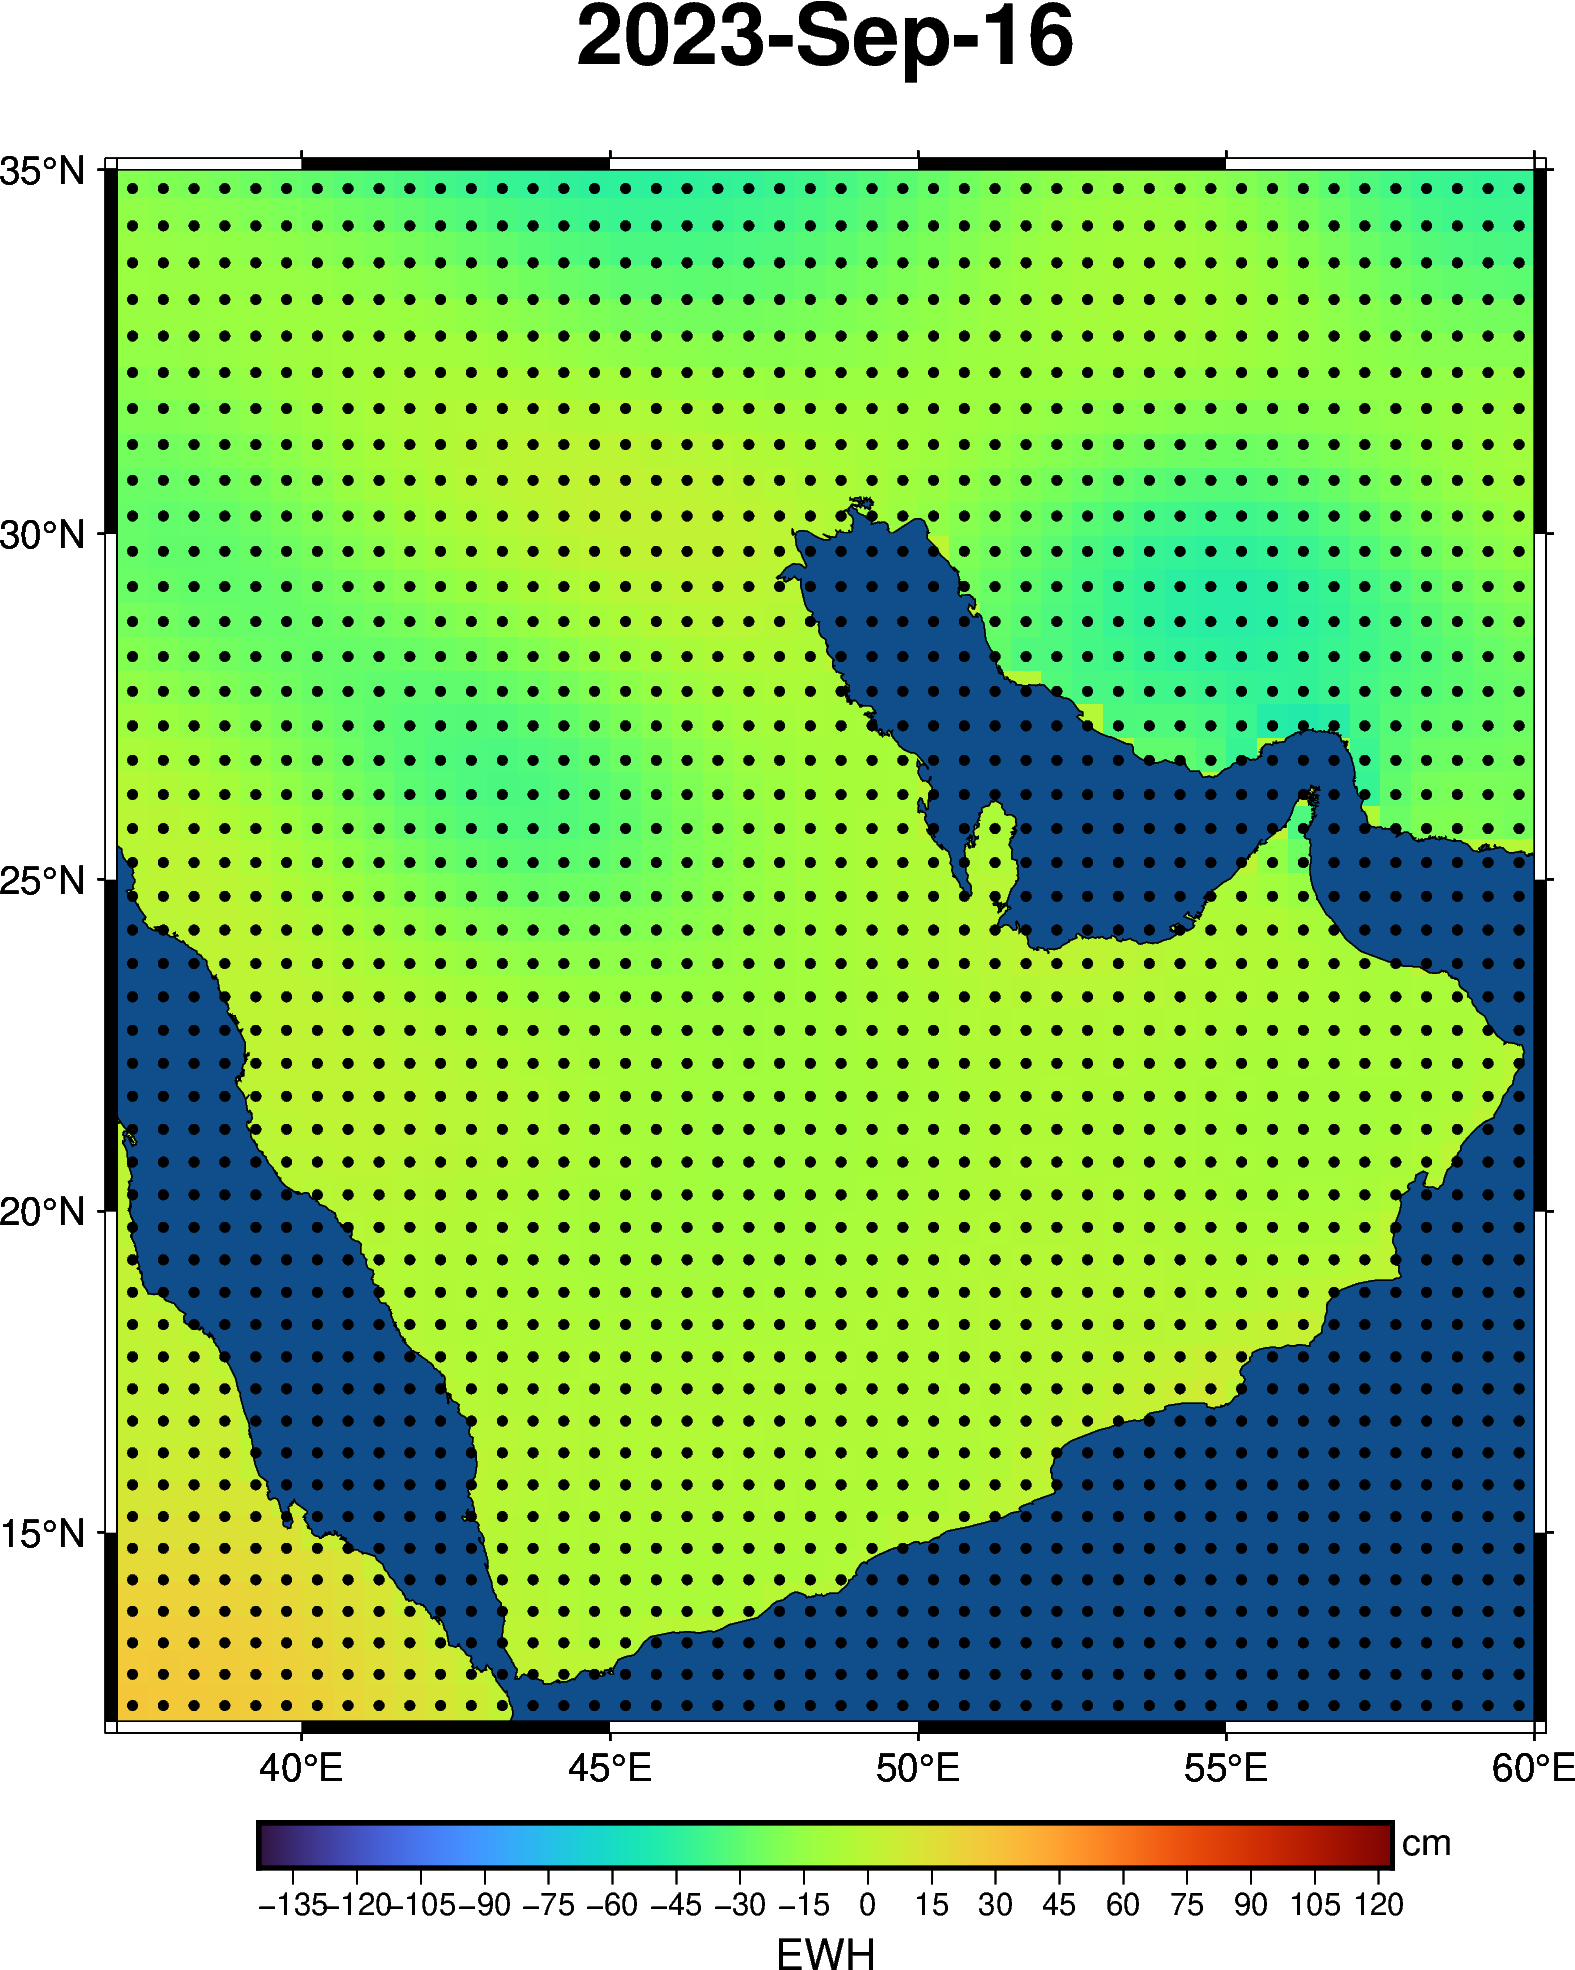

In [30]:
pdate = "2023-Sep-16"
idx = dates.index(pdate)

fig = pygmt.Figure()
fig.basemap(region=[37, 60, 12, 35], projection="M12c", frame=True)
fig.grdimage(grid=ewh[idx,:,:],projection="M12c")
fig.coast(shorelines=True, area_thresh=5000, water="dodgerblue4")
fig.plot(x=ll.ravel(), y=lt.ravel(), style="c.09c",fill="black")

fig.colorbar(frame=["a15", "x+lEWH", "y+lcm"])
fig.basemap(frame=["a", "+t"+dates[idx]])
fig.show()

Now, an example of how to get the time series at a location of longitude=10 and latitude=10 degrees.

In [31]:
lwe.isel(lat=10, lon=10).time.values # these are time epochs, you can see the gap between '2017-06-11T00:00:00.000000000' and '2018-06-16T00:00:00.000000000',

array(['2002-04-18T00:00:00.000000000', '2002-05-11T00:00:00.000000000',
       '2002-08-17T00:00:00.000000000', '2002-09-16T00:00:00.000000000',
       '2002-10-17T00:00:00.000000000', '2002-11-16T00:00:00.000000000',
       '2002-12-17T00:00:00.000000000', '2003-01-17T00:00:00.000000000',
       '2003-02-15T00:00:00.000000000', '2003-03-17T00:00:00.000000000',
       '2003-04-16T00:00:00.000000000', '2003-05-12T00:00:00.000000000',
       '2003-07-17T00:00:00.000000000', '2003-08-17T00:00:00.000000000',
       '2003-09-16T00:00:00.000000000', '2003-10-17T00:00:00.000000000',
       '2003-11-16T00:00:00.000000000', '2003-12-17T00:00:00.000000000',
       '2004-01-08T00:00:00.000000000', '2004-02-17T00:00:00.000000000',
       '2004-03-17T00:00:00.000000000', '2004-04-16T00:00:00.000000000',
       '2004-05-17T00:00:00.000000000', '2004-06-16T00:00:00.000000000',
       '2004-07-17T00:00:00.000000000', '2004-08-17T00:00:00.000000000',
       '2004-09-16T00:00:00.000000000', '2004-10-17

# Using ANN to predict the GAP values of Liquid Water Equivalent Thickness for one lat and lon combination

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Converting liquid water thickness values to dataframe

In [ ]:
# Convert xarray DataArray to DataFrame and getting only arabia region values
df = lwe.to_dataframe(name='lwe_thickness').reset_index()
df1 = df[(df['lat'] > 12) & (df['lat'] < 35) & (df['lon'] > 37) & (df['lon'] < 60)]
df1

,time,lat,lon,lwe_thickness
146954,2002-04-18,12.25,37.25,-12.205591
146955,2002-04-18,12.25,37.75,-11.305463
146956,2002-04-18,12.25,38.25,-10.478660
146957,2002-04-18,12.25,38.75,-9.156446
146958,2002-04-18,12.25,39.25,-7.815971
...,...,...,...,...
58240195,2023-09-16,34.75,57.75,-36.449810
58240196,2023-09-16,34.75,58.25,-39.391927
58240197,2023-09-16,34.75,58.75,-40.448233
58240198,2023-09-16,34.75,59.25,-41.745118


In [ ]:
# getting mesh or all combinations of lon and lat of arabia region
# region=[37, 60, 12, 35] # [lon_min, lon_max, lat_min, lat_max]

lat_lon_comb = df1[(df['time']=='2002-04-18')][['lat','lon']]
lat_lon_comb = lat_lon_comb.reset_index(inplace=False)
lat_lon_comb=lat_lon_comb.drop(['index'], axis=1)
lat_lon_comb

,lat,lon
0,12.25,37.25
1,12.25,37.75
2,12.25,38.25
3,12.25,38.75
4,12.25,39.25
...,...,...
2111,34.75,57.75
2112,34.75,58.25
2113,34.75,58.75
2114,34.75,59.25


## Defining Function to perform different functionality

In [ ]:
# function to get data of only one lon and lat for training and testin
def model_for_one_lat_lon(latt, lonn, lwe):
    lwe1d = lwe.sel(lat=latt, lon=lonn, method='nearest')
    lwe1d.plot(marker='o')
    df = pd.DataFrame(zip(lwe1d.time.values, lwe1d.values), columns=['time', 'lwet'])
    df['time'] = pd.to_datetime(df['time'])
    # Add columns for year and month
    df['year'] = df['time'].dt.year % 100  # Extract last two digits of the year
    df['month'] = df['time'].dt.month
    # Drop the original time column
    df.drop('time', axis=1, inplace=True)
    #  Normalize the data
    scaler = MinMaxScaler()
    scaler.fit(df[['lwet', 'year', 'month']])

    df[['lwet', 'year', 'month']] = scaler.transform(df[['lwet', 'year', 'month']])

    X = df[['year', 'month']].values
    y = df[['lwet']].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    return X_train, X_test, y_train, y_test, df.head(), lwe1d, scaler


# ANN model that is to be trained on data from model_for_one_lat_lon function
def modelll(X_train, y_train):
     # Build the neural network model
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
    # model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='RMSProp', loss='mean_squared_error')

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping])
    return model

# function to make predictions and calculating mean squared error
def mse_Xtest(model, xtest, ytest, scaler):
    predictions = model.predict(xtest)
    dummy_array = np.zeros((predictions.shape[0], 2))
    # Combine dummy_array with predictions
    combined_predictions = np.concatenate((dummy_array, predictions), axis=1)

    # Inverse transform the predictions to the original scale
    predictions_ = scaler.inverse_transform(combined_predictions)[:, -1]
    dummy_array = np.zeros((predictions.shape[0], 2))
    # Combine dummy_array with predictions
    combined_y_test = np.concatenate((dummy_array, ytest), axis=1)
    # Inverse transform the predictions to the original scale
    y_test_ = scaler.inverse_transform(combined_y_test)[:, -1]
    mse = mean_squared_error(y_test_, predictions_)
    print("Mean Squared Error ", mse)


## Function to predict the gap values

In [ ]:
def predicted_gap(lwe1d, model):
    test = pd.DataFrame(np.array([[17,17,17,17,17,17,18,18,18,18,18], [7,8,9,10,11,12,1,2,3,4,5]]).T, columns=['year', 'month'])
    predictions=model.predict(test)
    # Generate a timestamp range that are missing
    timestamp_range = pd.date_range(start='2017-07-01', end='2018-06-01', freq='ME')

    result = pd.DataFrame(zip(timestamp_range, predictions.reshape(-1,)), columns=['time', 'lwet'])

    dfff = pd.DataFrame(zip(lwe1d.time.values, lwe1d.values), columns=['time', 'lwet'])
    df_before = dfff[dfff.time<='2017-06-11']  # split data after 2017-06-11  into two parts
    df_after = dfff[dfff.time>'2017-06-11']
    merged_df = pd.concat([df_before, result, df_after], ignore_index=True)  # merge all three dataframes to new dataframe
    return result, merged_df



## Main function to call all functions

In [ ]:
def main(latt, lonn, lwe):
    X_train, X_test, y_train, y_test, df_h, lwe1d, scaler = model_for_one_lat_lon(latt, lonn, lwe)
    model = modelll(X_train=X_train, y_train=y_train)
    mse = mse_Xtest(model=model, xtest=X_test, ytest=y_test, scaler=scaler)
    result, merged_df = predicted_gap(lwe1d, model)
    return merged_df

## predicting 10 random arabia regions values

20.25 49.25
Epoch 1/100
12/12 [==============================] - 0s 9ms/step - loss: 0.1432 - val_loss: 0.0740
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1069 - val_loss: 0.1160
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0906 - val_loss: 0.1487
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0798 - val_loss: 0.1789
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0725 - val_loss: 0.1810
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0666 - val_loss: 0.1614
Epoch 7/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0616 - val_loss: 0.1534
Epoch 8/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0572 - val_loss: 0.1404
Epoch 9/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0528 - val_loss: 0.1245
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0485 - val_loss: 0.11

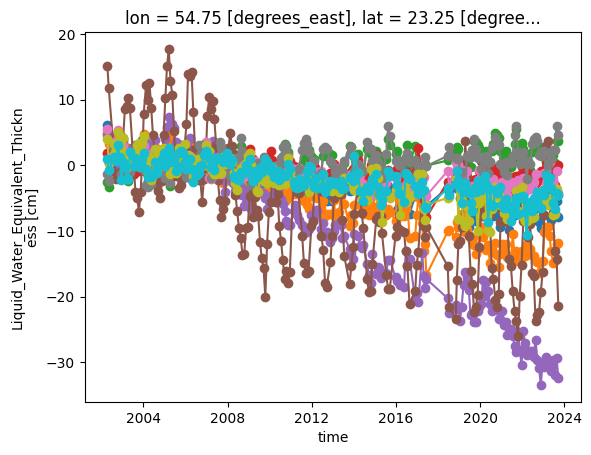

In [ ]:
lat_lon_comb_s = lat_lon_comb.sample(11)
resultt = pd.DataFrame([[' ',' ']],[' ',' '], columns=['time', 'lwet'])
for i in range(10):
    latt, lonn = lat_lon_comb_s.iloc[i]
    print(latt, lonn)
    mdf = main(latt=latt, lonn=lonn, lwe=lwe)
    lat_lon = pd.DataFrame([[latt,lonn]], columns=['time', 'lwet'])
    resultt = np.concatenate((resultt,lat_lon, mdf), axis=0)

In [ ]:
pd.DataFrame(resultt).to_csv('ten arabia regions predicted values.csv')

We plot the time series

# RandomForestRegressor to predict all arabia regions water thickness values

In [7]:
df = lwe.to_dataframe(name='lwe_thickness').reset_index()
df1 = df[(df['lat'] > 12) & (df['lat'] < 35) & (df['lon'] > 37) & (df['lon'] < 60)]
df1.head()

,time,lat,lon,lwe_thickness
146954,2002-04-18,12.25,37.25,-12.205591
146955,2002-04-18,12.25,37.75,-11.305463
146956,2002-04-18,12.25,38.25,-10.478660
146957,2002-04-18,12.25,38.75,-9.156446
146958,2002-04-18,12.25,39.25,-7.815971


In [8]:
df1['time'] = pd.to_datetime(df1['time'])
# Add columns for year and month
df1['year'] = df1['time'].dt.year % 100  # Extract last two digits of the year
df1['month'] = df1['time'].dt.month

df1.head()

C:\Users\PMYLS\AppData\Local\Temp\ipykernel_12256\2831345368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = pd.to_datetime(df1['time'])
C:\Users\PMYLS\AppData\Local\Temp\ipykernel_12256\2831345368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['year'] = df1['time'].dt.year % 100  # Extract last two digits of the year
C:\Users\PMYLS\AppData\Local\Temp\ipykernel_12256\2831345368.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,time,lat,lon,lwe_thickness,year,month
146954,2002-04-18,12.25,37.25,-12.205591,2,4
146955,2002-04-18,12.25,37.75,-11.305463,2,4
146956,2002-04-18,12.25,38.25,-10.478660,2,4
146957,2002-04-18,12.25,38.75,-9.156446,2,4
146958,2002-04-18,12.25,39.25,-7.815971,2,4


In [9]:
df2 = df1.drop(['time'], axis=1)
df2.head()

,lat,lon,lwe_thickness,year,month
146954,12.25,37.25,-12.205591,2,4
146955,12.25,37.75,-11.305463,2,4
146956,12.25,38.25,-10.478660,2,4
146957,12.25,38.75,-9.156446,2,4
146958,12.25,39.25,-7.815971,2,4


In [13]:
df2.sample(10)

,lat,lon,lwe_thickness,year,month
15968956,19.75,38.25,-26.665686,7,8
58223637,23.25,58.75,-7.869419,23,9
18831707,27.75,53.75,-10.405405,8,7
8195878,21.75,59.25,2.640237,5,2
17532086,25.25,43.25,-0.153432,8,2
29450242,21.75,41.25,-2.000786,12,2
48106919,17.75,59.75,-1.410277,20,6
43435552,13.75,56.25,0.674041,18,12
18049069,24.25,54.75,-2.454455,8,4
46036164,19.75,42.25,-8.631668,19,10


In [10]:
X = df2[['lat', 'lon', 'year', 'month']].values
y = df2[['lwe_thickness']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the model
model1 = RandomForestRegressor(n_estimators=100, random_state=4)
model1.fit(X_train, y_train)
predictions1 = model1.predict(X_test)
mse1 = mean_squared_error(y_test, predictions1)
print("Mean Squared Error ", mse1)

<ipython-input-18-e5fbddc831f7>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model1.fit(X_train, y_train)


Mean Squared Error  0.885444404709113


In [20]:
model1.predict([[12.25,	37.25,	2,	4]])

array([-12.45889842])

In [11]:
lat_lon_comb = df1[(df1['time']=='2002-04-18')][['lat','lon']]
lat_lon_comb = lat_lon_comb.reset_index(inplace=False)
lat_lon_comb=lat_lon_comb.drop(['index'], axis=1)
lat_lon_comb

,lat,lon
0,12.25,37.25
1,12.25,37.75
2,12.25,38.25
3,12.25,38.75
4,12.25,39.25
...,...,...
2111,34.75,57.75
2112,34.75,58.25
2113,34.75,58.75
2114,34.75,59.25


In [43]:
# Generate monthly timestamps
timestamps = pd.date_range('2017-06-30', '2018-05-31', freq='M')

# Repeat the existing DataFrame for each timestamp
test_df = pd.concat([lat_lon_comb.assign(timestamp=timestamp) for timestamp in timestamps], ignore_index=True)

# Print the resulting DataFrame
print(test_df)

         lat    lon  timestamp
0      12.25  37.25 2017-06-30
1      12.25  37.75 2017-06-30
2      12.25  38.25 2017-06-30
3      12.25  38.75 2017-06-30
4      12.25  39.25 2017-06-30
...      ...    ...        ...
25387  34.75  57.75 2018-05-31
25388  34.75  58.25 2018-05-31
25389  34.75  58.75 2018-05-31
25390  34.75  59.25 2018-05-31
25391  34.75  59.75 2018-05-31

[25392 rows x 3 columns]


In [44]:
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
# Add columns for year and month
test_df['year'] = test_df['timestamp'].dt.year % 100  # Extract last two digits of the year
test_df['month'] = test_df['timestamp'].dt.month

test_df

,lat,lon,timestamp,year,month
0,12.25,37.25,2017-06-30,17,6
1,12.25,37.75,2017-06-30,17,6
2,12.25,38.25,2017-06-30,17,6
3,12.25,38.75,2017-06-30,17,6
4,12.25,39.25,2017-06-30,17,6
...,...,...,...,...,...
25387,34.75,57.75,2018-05-31,18,5
25388,34.75,58.25,2018-05-31,18,5
25389,34.75,58.75,2018-05-31,18,5
25390,34.75,59.25,2018-05-31,18,5


In [21]:
predicted_data = model1.predict(test_df[['lat', 'lon', 'year', 'month']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
predicted_data

array([ -5.01426704,  -3.12787559,  -2.0342467 , ..., -21.86465602,
       -21.47466549, -20.77732499])

In [22]:
predicted_tests = test_df.copy()

In [23]:
predicted_tests['lwe_thickness']=predicted_data

In [24]:
predicted_tests = predicted_tests[['timestamp', 'lat', 'lon', 'lwe_thickness']]

In [25]:
predicted_tests.columns=['time', 'lat', 'lon', 'lwe_thickness']

In [26]:
predicted_tests.sample(10)

,time,lat,lon,lwe_thickness
25156,2018-05-31,32.25,57.25,-9.324110
18272,2018-02-28,26.75,42.25,-18.360499
5938,2017-08-31,30.75,39.25,-17.759951
15129,2018-01-31,15.25,57.75,0.289475
19114,2018-03-31,12.75,49.25,-1.893988
9937,2017-10-31,28.25,37.75,-20.507640
4244,2017-08-31,12.25,43.25,-1.699038
14641,2017-12-31,33.25,43.75,-14.016725
15616,2018-01-31,20.75,48.25,-4.694853
11314,2017-11-30,19.75,59.25,2.573351


In [27]:
df_before = df1[df1.time<='2017-06-11']  # split data after 2017-06-11  into two parts
df_after = df1[df1.time>'2017-06-11']
combined_results = pd.concat([df_before[['time', 'lat', 'lon', 'lwe_thickness']], predicted_tests, df_after[['time', 'lat', 'lon', 'lwe_thickness']]], ignore_index=True)  # merge all three dataframes to new dataframe
combined_results.to_csv("Grace and Grace Fo with Predicted gap values.csv")

# Predicting the GAP values of liquid water thickness between GRACE and GRACE FO missions of all arabia regions using ANN

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Data Preprocessing

In [33]:
# filter all the arabia region values
df = lwe.to_dataframe(name='lwe_thickness').reset_index()
df1 = df[(df['lat'] > 12) & (df['lat'] < 35) & (df['lon'] > 37) & (df['lon'] < 60)]
df1.head()

,time,lat,lon,lwe_thickness
146954,2002-04-18,12.25,37.25,-12.205591
146955,2002-04-18,12.25,37.75,-11.305463
146956,2002-04-18,12.25,38.25,-10.478660
146957,2002-04-18,12.25,38.75,-9.156446
146958,2002-04-18,12.25,39.25,-7.815971


In [34]:
df1['time'] = pd.to_datetime(df1['time'])
# Add columns for year and month
df1['year'] = df1['time'].dt.year % 100  # Extract last two digits of the year
df1['month'] = df1['time'].dt.month

C:\Users\PMYLS\AppData\Local\Temp\ipykernel_14100\2471030324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = pd.to_datetime(df1['time'])
C:\Users\PMYLS\AppData\Local\Temp\ipykernel_14100\2471030324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['year'] = df1['time'].dt.year % 100  # Extract last two digits of the year
C:\Users\PMYLS\AppData\Local\Temp\ipykernel_14100\2471030324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [35]:
df1.head()

,time,lat,lon,lwe_thickness,year,month
146954,2002-04-18,12.25,37.25,-12.205591,2,4
146955,2002-04-18,12.25,37.75,-11.305463,2,4
146956,2002-04-18,12.25,38.25,-10.478660,2,4
146957,2002-04-18,12.25,38.75,-9.156446,2,4
146958,2002-04-18,12.25,39.25,-7.815971,2,4


## Data splitting

In [36]:
df1.head()
df2 = df1.drop(['time'], axis=1)

X = df2[['lat', 'lon', 'year', 'month']].values
y = df2[['lwe_thickness']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Building the Model

In [37]:
def better_model(X_train):
    model = Sequential()
    
    # Add input layer
    model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))

    # Add hidden layers
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))

    # Add output layer
    model.add(Dense(units=1, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error',)  # Changed optimizer to Adam

    return model


## Data Normalization

In [38]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(380880, 4) (95220, 4) (380880, 1) (95220, 1)


In [39]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaler.fit(X_train)  # normalizing x data
y_scaler.fit(y_train)  # normalizing y data

X_train_scaled = X_scaler.transform(X_train)
y_train_scaled = y_scaler.transform(y_train)

## Model Training

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model = better_model(X_train) # call the model function
    # Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=128, validation_split=0.1, callbacks=[early_stopping]) # train the model

Epoch 1/100
2679/2679 [==============================] - 7s 2ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 2/100
2679/2679 [==============================] - 6s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/100
2679/2679 [==============================] - 6s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/100
2679/2679 [==============================] - 6s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/100
2679/2679 [==============================] - 6s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/100
2679/2679 [==============================] - 7s 2ms/step - loss: 0.0010 - val_loss: 9.6038e-04
Epoch 7/100
2679/2679 [==============================] - 6s 2ms/step - loss: 9.5602e-04 - val_loss: 9.0390e-04
Epoch 8/100
2679/2679 [==============================] - 6s 2ms/step - loss: 9.2466e-04 - val_loss: 9.2886e-04
Epoch 9/100
2679/2679 [==============================] - 6s 2ms/step - loss: 8.5612e-04 - val_loss: 8.8455e-04
Epoch 10/100
2679/2679 [=====================

## Plotting model results 

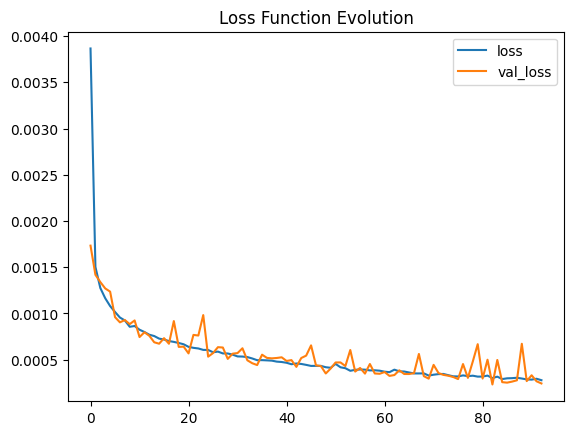

In [45]:
import matplotlib.pyplot as plt
# visulizing the loss and val_loss 
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss Function Evolution')
plt.legend()

In [40]:
from tensorflow.keras.models import load_model
model = load_model('ANN-GRACE.h5')

In [41]:
# making predictions on X_test data
X_test_preds = model.predict(X_scaler.transform(X_test))

2976/2976 [==============================] - 13s 4ms/step


In [42]:
# making prediction on single example
y_scaler.inverse_transform(model.predict(X_scaler.transform([[12.25,	37.25,	2,	4]])))

1/1 [==============================] - 0s 57ms/step


array([[-12.304227]], dtype=float32)

## ANN Evaluation Metrices 

In [43]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

print("ANN root_mean_squared_error: ", root_mean_squared_error(y_test, y_scaler.inverse_transform(X_test_preds)))
print("ANN mean_squared_error: ", mean_squared_error(y_test, y_scaler.inverse_transform(X_test_preds)))
print("ANN mean_absolute_error: ", mean_absolute_error(y_test, y_scaler.inverse_transform(X_test_preds)))
print("ANN r2_score: ", r2_score(y_test, y_scaler.inverse_transform(X_test_preds)))

ANN root_mean_squared_error:  1.33166462993596
ANN mean_squared_error:  1.7733306866224776
ANN mean_absolute_error:  0.9236752907779127
ANN r2_score:  0.9740793586000347


## Explanation of above results
- `R-squared` represents the proportion of the variance in the dependent variable that is predictable from the independent variables.
Values range from 0 to 1, where close to 1 indicates perfect prediction. in our case r2_score is close to 1.

- `Mean Absolute Error (MAE)`, lower values are desirable. MAE represents the average absolute difference between the predicted and actual values. A lower MAE indicates that, on average, the model's predictions are closer to the actual values. in our case MAE is 0.94 which is quit low and represent good results.

- `mean absolute error(MSE)` is the average absolute differences between predicted and actual values.

## Predicting the gap values

In [53]:
# Generate monthly timestamps
timestamps = pd.date_range('2017-06-30', '2018-05-31', freq='M')

# Repeat the existing DataFrame for each timestamp
test_df = pd.concat([lat_lon_comb.assign(timestamp=timestamp) for timestamp in timestamps], ignore_index=True)

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
# Add columns for year and month
test_df['year'] = test_df['timestamp'].dt.year % 100  # Extract last two digits of the year
test_df['month'] = test_df['timestamp'].dt.month

test_df

C:\Users\PMYLS\AppData\Local\Temp\ipykernel_12256\2582645548.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  timestamps = pd.date_range('2017-06-30', '2018-05-31', freq='M')


,lat,lon,timestamp,year,month
0,12.25,37.25,2017-06-30,17,6
1,12.25,37.75,2017-06-30,17,6
2,12.25,38.25,2017-06-30,17,6
3,12.25,38.75,2017-06-30,17,6
4,12.25,39.25,2017-06-30,17,6
...,...,...,...,...,...
25387,34.75,57.75,2018-05-31,18,5
25388,34.75,58.25,2018-05-31,18,5
25389,34.75,58.75,2018-05-31,18,5
25390,34.75,59.25,2018-05-31,18,5


In [55]:
ann_predictions = model.predict(X_scaler.transform((test_df[['lat', 'lon', 'year', 'month']]).values))

794/794 [==============================] - 3s 4ms/step


In [58]:
predicted_tests1 = test_df.copy()

## Combining the GAP and Original values

In [61]:
predicted_tests1['lwe_thickness']=y_scaler.inverse_transform(ann_predictions)
predicted_tests1 = predicted_tests1[['timestamp', 'lat', 'lon', 'lwe_thickness']]
predicted_tests1.columns=['time', 'lat', 'lon', 'lwe_thickness']

df_before = df1[df1.time<='2017-06-11']  # split data after 2017-06-11  into two parts
df_after = df1[df1.time>'2017-06-11']
combined_results1 = pd.concat([df_before[['time', 'lat', 'lon', 'lwe_thickness']], predicted_tests1, df_after[['time', 'lat', 'lon', 'lwe_thickness']]], ignore_index=True)  # merge all three dataframes to new dataframe
combined_results1.to_csv("ANN Predicted gap values.csv")

In [62]:
model.save("ANN-GRACE.h5")

c:\Users\PMYLS\envs\gm\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## printing model summary

In [67]:
from tensorflow.keras.models import load_model
modal = load_model('ANN-GRACE.h5')
modal.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 128)               640       
                                                                 
 dense_46 (Dense)            (None, 256)               33024     
                                                                 
 dense_47 (Dense)            (None, 128)               32896     
                                                                 
 dense_48 (Dense)            (None, 64)                8256      
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 1)                 33        
                                                                 
Total params: 76929 (300.50 KB)
Trainable params: 7692